# Allow list approach with image redaction
This notebook covers how to use the `allow_list` argument to prevent certain words from being redacted from images and explains how you can use this to implement a strict redact all text approach.

> **Note**: Always place the `allow_list` argument last in your redact call as this is considered a text analyzer kwarg.

## Prerequisites
Before getting started, make sure presidio and the latest version of Tesseract OCR are installed. For detailed documentation, see the [installation docs](https://microsoft.github.io/presidio/installation).

In [ ]:
!pip install presidio_analyzer presidio_anonymizer presidio_image_redactor
!python -m spacy download en_core_web_lg

## 0. Imports and initializations

In [1]:
from PIL import Image
import pydicom
from presidio_analyzer import Pattern, PatternRecognizer
from presidio_image_redactor import ImageRedactorEngine, DicomImageRedactorEngine
import matplotlib.pyplot as plt

Initialize engines used for image redaction

In [2]:
# Standard images
engine = ImageRedactorEngine()

# DICOM images
dicom_engine = DicomImageRedactorEngine()
padding_width = 3
fill = "background"

## 1. Example images
In this notebook, we will use the following examples images.

### 1.1 Standard example image

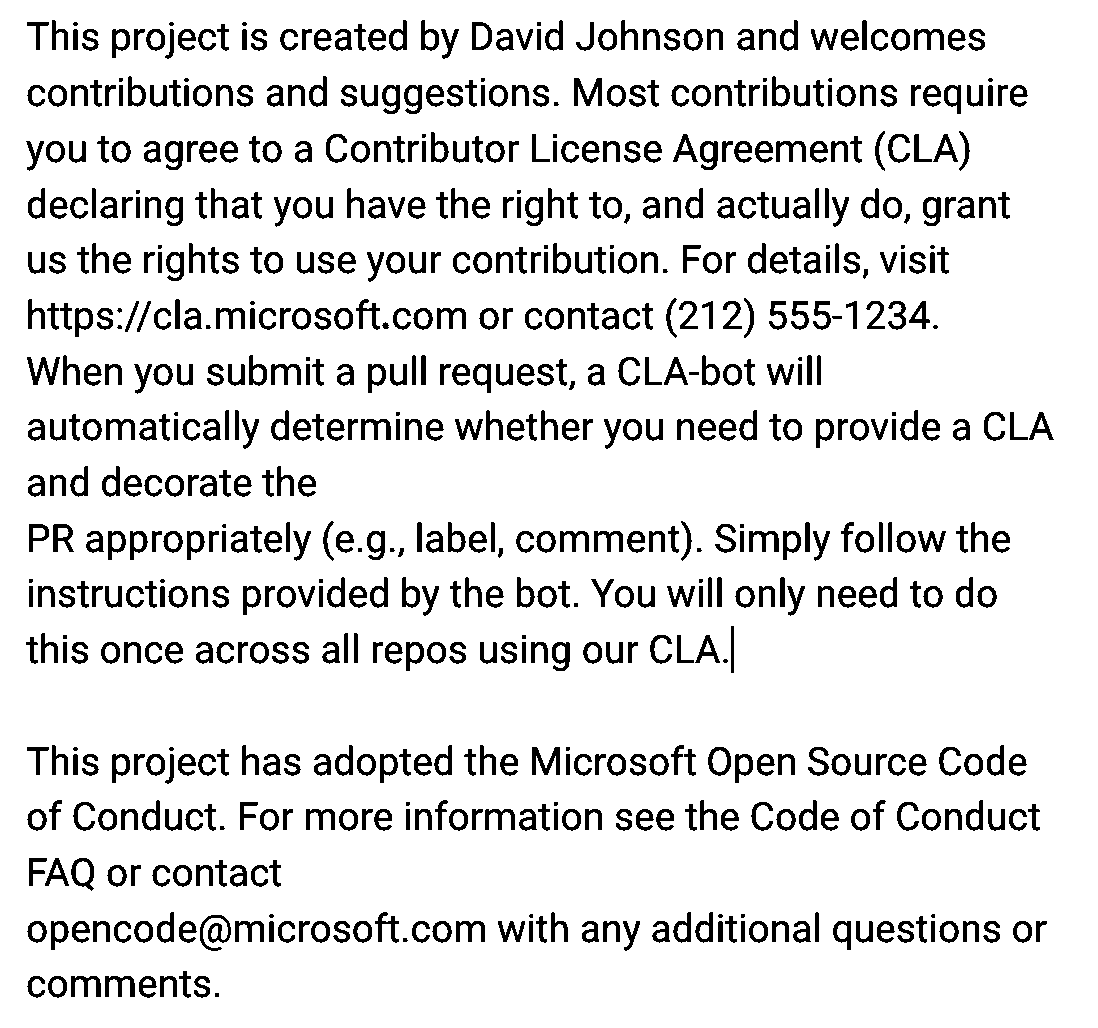

In [3]:
image = Image.open("../../image-redactor/ocr_text.png")
display(image)

And this is what the image looks like with the standard, default behavior redaction.

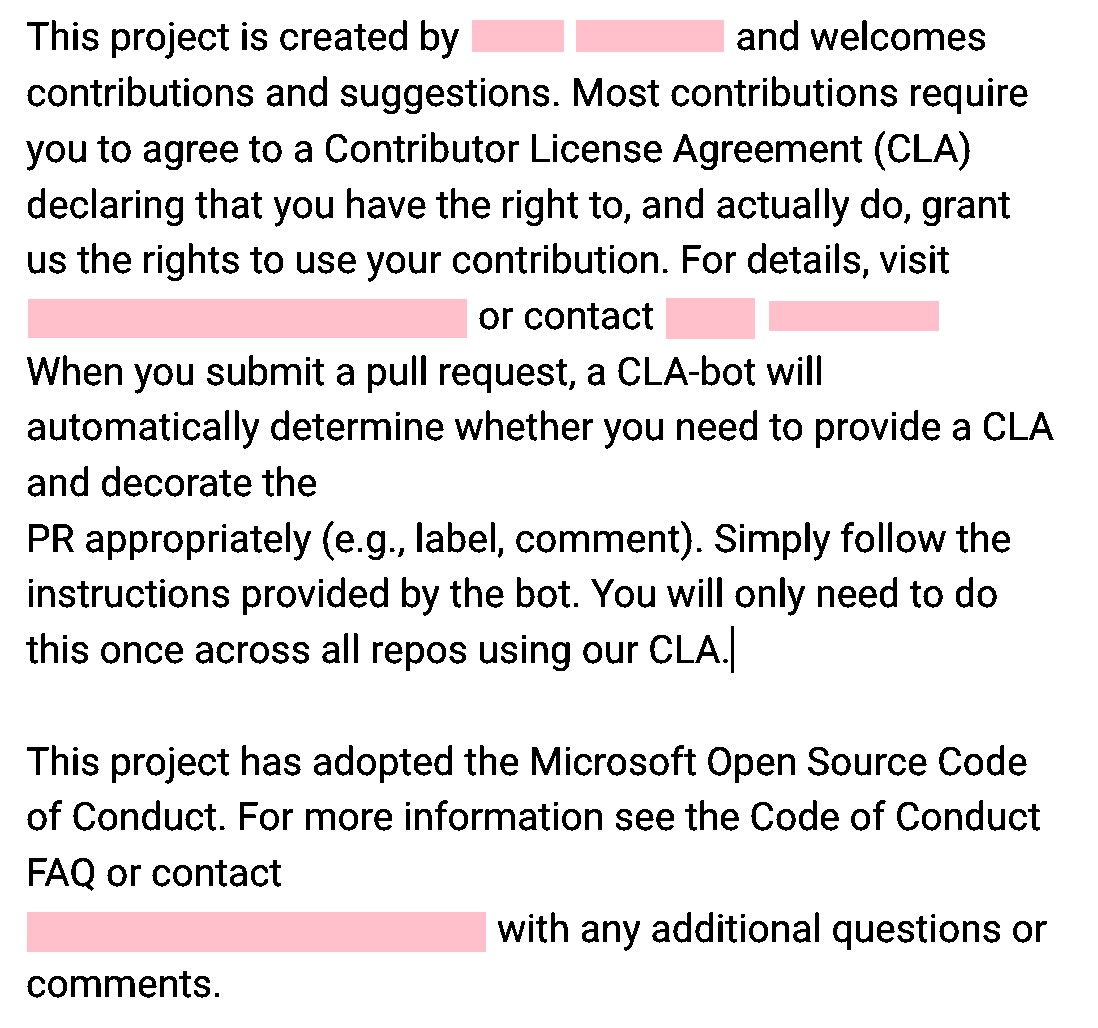

In [4]:
redacted_image = engine.redact(image, (255, 192, 203))
display(redacted_image)

### 1.2 DICOM medical image
For more information on DICOM image redaction, please see [example_dicom_image_redactor.ipynb](./example_dicom_image_redactor.ipynb) and the [Image redactor module documentation](../../image-redactor/index.md).

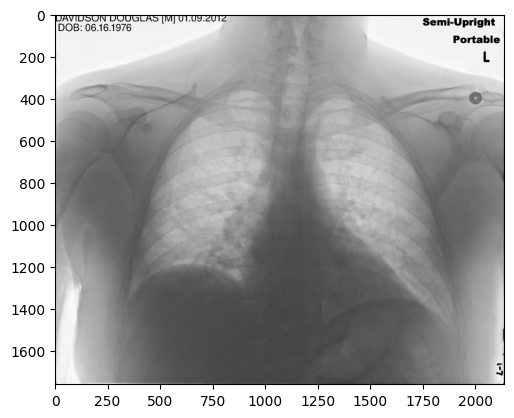

In [5]:
instance = pydicom.dcmread("./sample_data/0_ORIGINAL.dcm")
plt.imshow(instance.pixel_array, cmap="gray")

And this is what the image looks like with the standard, default behavior redaction.

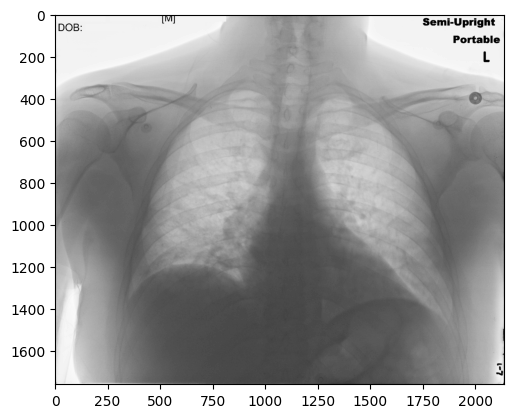

In [6]:
results = dicom_engine.redact(instance, padding_width=padding_width, fill=fill)
plt.imshow(results.pixel_array, cmap="gray")

## 2. Scenario: Prevent some words from being redacted
Whether using the default recognizer, registering your own custom recognizer, or using ad-hoc recognizers to identify sensitive entities, there may be times where you **do not** want certain words redacted.

In these cases, we can use the `allow_list` argument passed into the `ImageAnalyzerEngine` via our redact engine to preserve specified strings.

> **Note**: The `allow_list` argument should be positioned as the last argument in the redact call as it is considered a text analyzer kwarg.

Redacted image when using the allow list approach

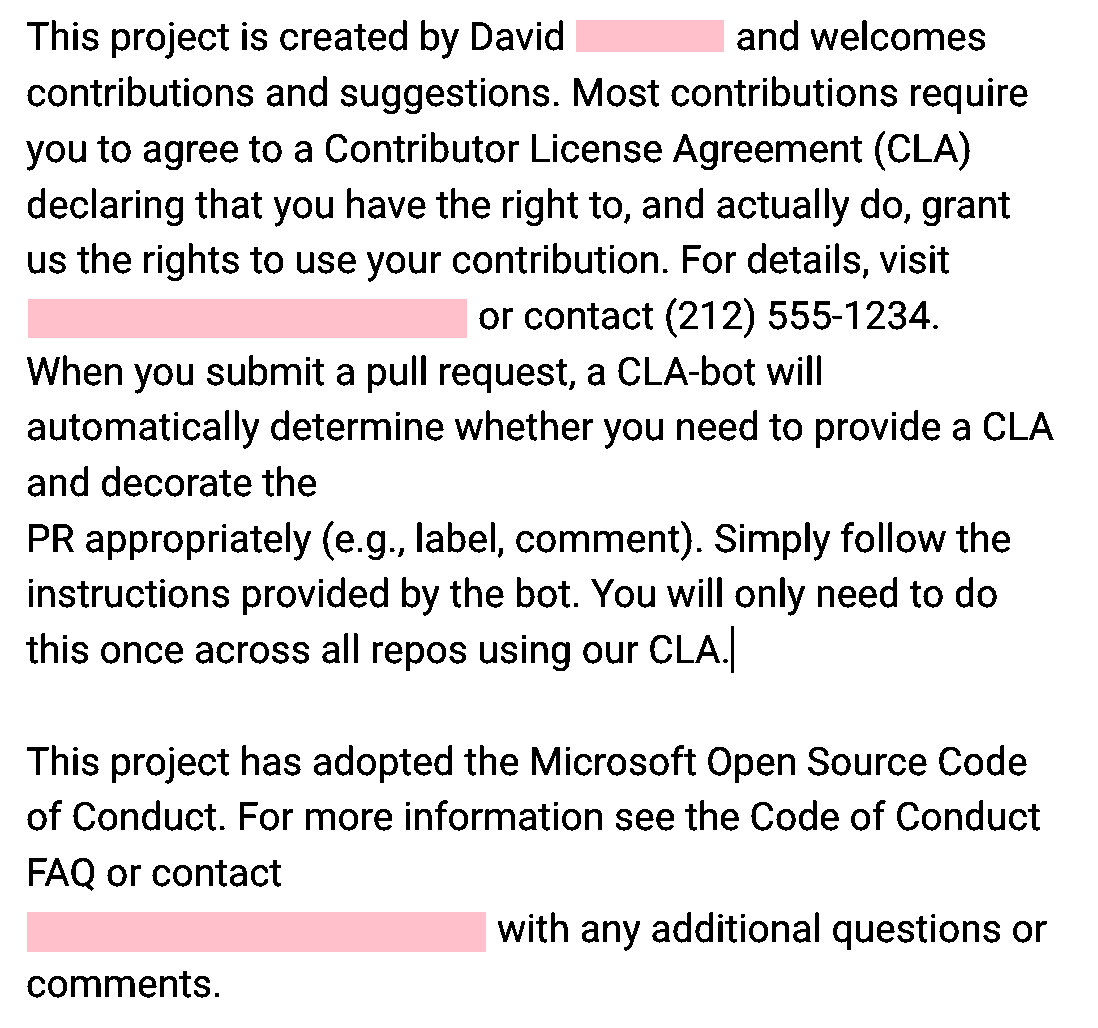

In [7]:
redacted_image = engine.redact(image, (255, 192, 203), allow_list=["David", "(212) 555-1234"])
display(redacted_image)

Redacted DICOM image when using the allow list approach

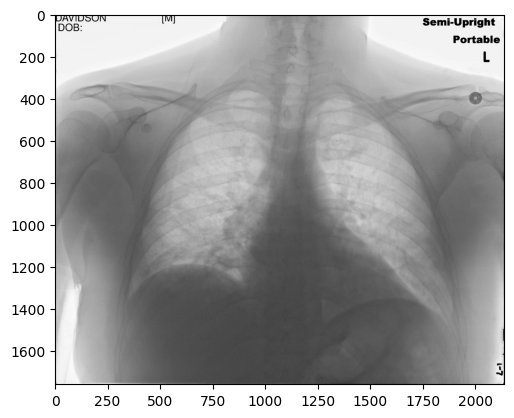

In [8]:
results = dicom_engine.redact(instance, padding_width=padding_width, fill=fill, allow_list=["DAVIDSON"])
plt.imshow(results.pixel_array, cmap="gray")

## 3. Scenario : Only allow specific words while redacting all other text
In some cases, we want to preserve certain words and redact all other text in the image. We can create an ad-hoc recognizer that considers all text as sensitive and couple that with the allow list.

> **Note**: The `allow_list` argument should be positioned as the last argument in the redact call as it is considered a text analyzer kwarg.

Create a custom recognizer to mark all text as sensitive

In [9]:
pattern_all_text = Pattern(name="any_text", regex=r"(?s).*", score=0.5)
custom_recognizer = PatternRecognizer(
    supported_entity="TEXT",
    patterns=[pattern_all_text],
)

Then pass that custom recognizer into your redactor engine as an ad-hoc recognizer

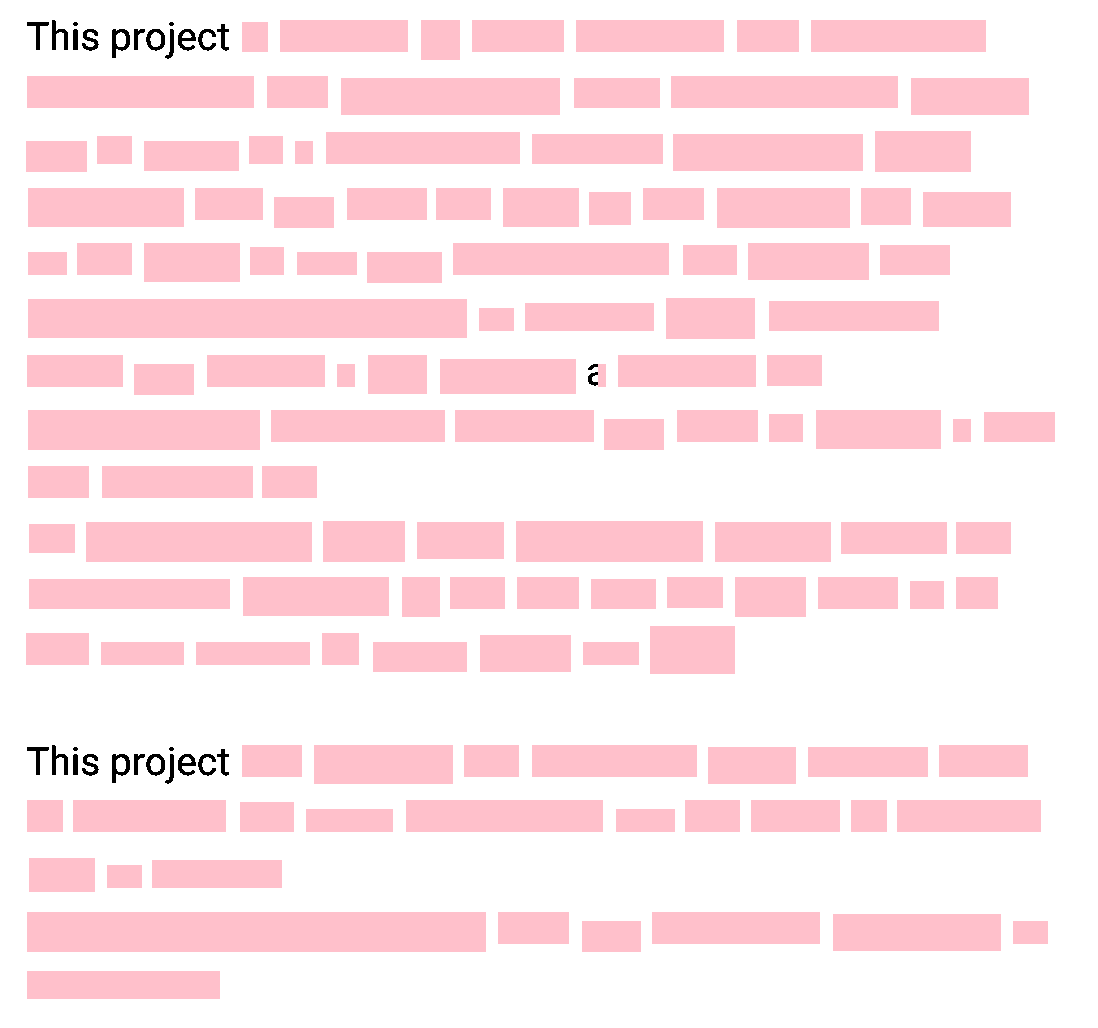

In [10]:
# Standard image
redacted_image = engine.redact(
    image,
    (255, 192, 203),
    ad_hoc_recognizers = [custom_recognizer], # you can pass in multiple ad-hoc recognizers
    allow_list=["This", "project",]
)
display(redacted_image)

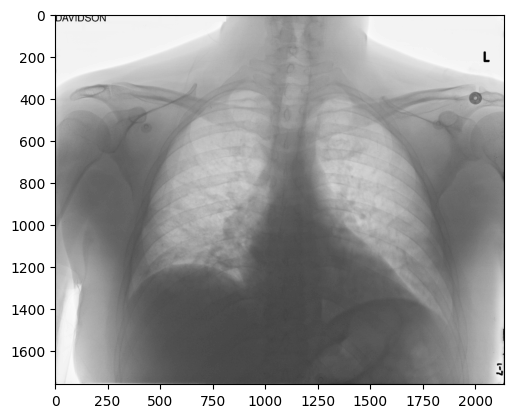

In [11]:
# DICOM image
results = dicom_engine.redact(
    instance,
    padding_width = padding_width,
    fill = fill,
    ad_hoc_recognizers = [custom_recognizer], # you can pass in multiple ad-hoc recognizers
    allow_list = ["DAVIDSON", "L"]
)
plt.imshow(results.pixel_array, cmap="gray")

## 4. Scenario: Redact all text on the image
When it is critical to minimize False Negatives during the redaction process, we recommend using a "redact all" approach to redact all detected text.

As with the other scenarios, good OCR performance is critical in ensuring the analyzer can pick up on all text in the image. False Negatives may still occur with images if the OCR fails to pick up on all the text.

> **Note**: The `allow_list` argument should be positioned as the last argument in the redact call as it is considered a text analyzer kwarg.

Create a custom recognizer that marks all text as sensitive

In [12]:
pattern_all_text = Pattern(name="any_text", regex=r"(?s).*", score=0.5)
custom_recognizer = PatternRecognizer(
    supported_entity="TEXT",
    patterns=[pattern_all_text],
)

Specify an empty allow list such that no text is allowed

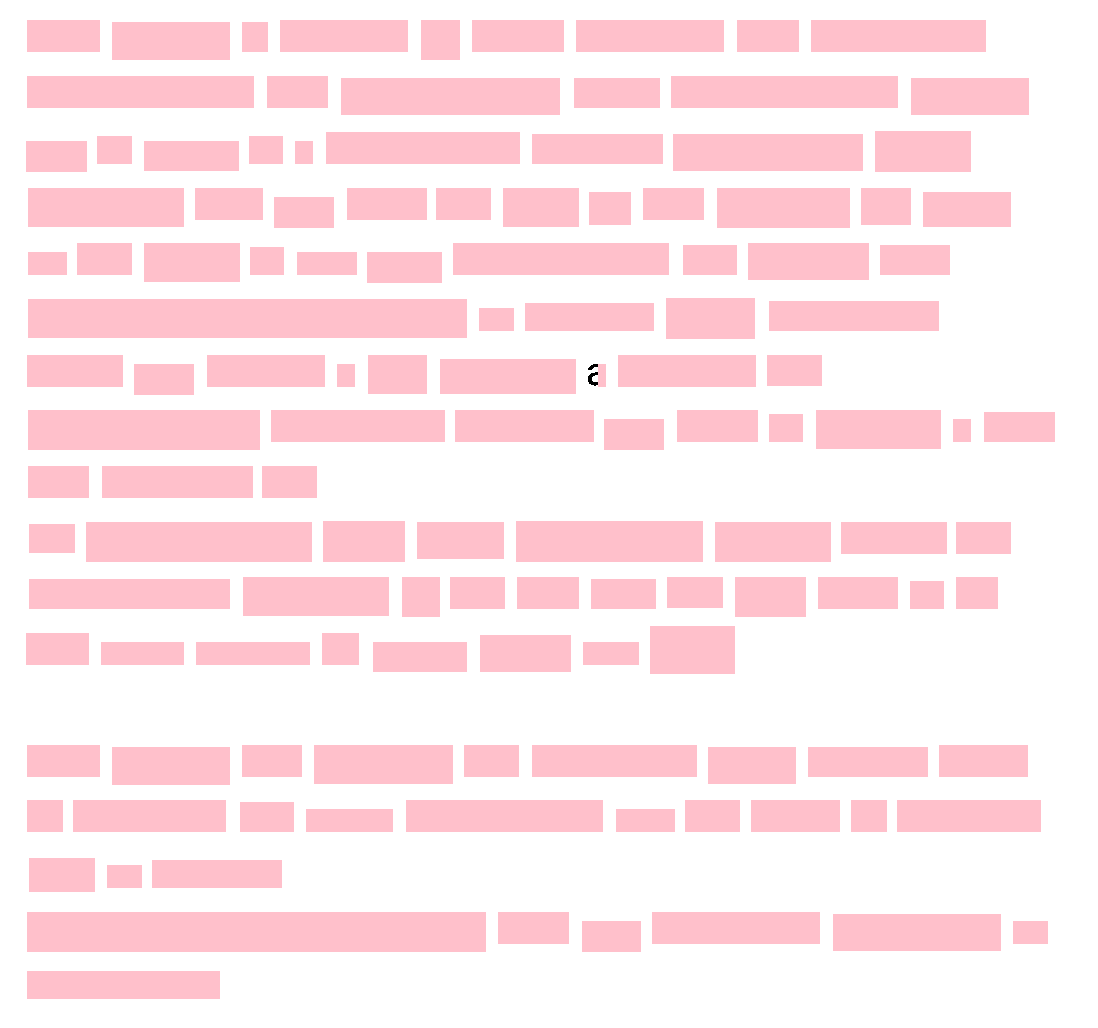

In [13]:
# Standard image
redacted_image = engine.redact(
    image,
    (255, 192, 203),
    ad_hoc_recognizers = [custom_recognizer],
    allow_list=[]
)
display(redacted_image)

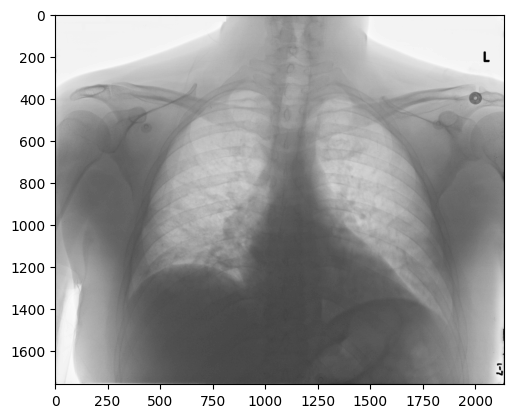

In [14]:
# DICOM image
results = dicom_engine.redact(
    instance,
    padding_width = padding_width,
    fill = fill,
    ad_hoc_recognizers = [custom_recognizer],
    allow_list = []
)
plt.imshow(results.pixel_array, cmap="gray")

In this case, we see that all text picked up by the OCR is redacted. The "L" on the right side of the DICOM image and the single "a" in the standard image are still visible because they were not detected by the OCR.

## Conclusion
The `allow_list` argument can be used in both standard and DICOM iamge redaction to allow specified words to avoid redaction. This can also be used to redact all detected text.

While this approach allows for the greatest recall in terms of redacting sensitive text, it is dependent on the performance of the text detection which comes before analysis.


### Tips for improved performance
1. To avoid False Negative redaction, we recommend applying preprocessing techniques or experimenting with parameters to improve OCR performance or use an alternative approach to improve text detection. We are actively working on adding a preprocessing module to allow for easy application of image preprocessing methods.
2. We recommend augmenting your allowlist to consider various casing and punctuation.